## Amazon Book Review
This repository contains the basic process notebook for Group 42's project, which analyzes the tendency of users to overrate items.

Due to the computational requirements of processing the full 500,000-review dataset, this notebook provides a representative demonstration using a 100-sample subset. The processes outlined here reflect the methodology applied to the entire dataset. Important Note: Because this notebook uses only the subset, all resulting plots, summary statistics, and model output do not reflect the final figures used in the official report; they serve purely as an illustration of the process. Following steps are contained.


0. Data loading
1. Preprocessing
1.1 Preprocessing Minhashing

2. Create Embeddings
2.1 Minhashing
2.2 SBert

3. Clustering for Minhashing
3.1 K-Means
3.2 HDBscan with UMAP

4. Clustering with SBert
4.1 Preprocessing for Cluster
4.2 K-Means
4.3 HDBSCAN

5. Analysis




#### 0. Data loading

In [99]:
# load dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import html
import collections
from collections import Counter

import os
import sys
import argparse
import logging
from datetime import datetime

import numpy as np
import pandas as pd
from tqdm import tqdm

import pyarrow as pa
import pyarrow.parquet as pq
from sentence_transformers import SentenceTransformer

from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import torch.nn.functional as F

import fasttext
from tqdm import tqdm

import numpy as np
import pyarrow as pa
import pyarrow.parquet as pq
from tqdm import tqdm
from pathlib import Path
import glob

from sklearn.decomposition import PCA

from sklearn.cluster import KMeans, DBSCAN
import hdbscan
from sklearn.metrics import davies_bouldin_score
import pandas as pd
import matplotlib.pyplot as plt
import umap

In [ ]:
# load data
path_book_reviews = "100_reviews.csv" #### SET THE PATH
br = pd.read_csv(path_book_reviews)


In [64]:
print(len(br))

100


#### 1. Preprocessing

##### 1.1 Preprocessing 

In [ ]:
#filter columns
br = br[['Id','review/score', 'review/text']]
#drop NA values
br = br.dropna(subset=['review/text', 'review/score'])
#unescape html characters
br['cleanText'] = br['review/text'].astype(str).apply(html.unescape)

In [13]:
# --- Combined cleaning function ---
def clean_text_all(text):
    text = str(text)

    # 1. Remove control characters (non-printable ASCII)
    # \x00-\x1F are control chars, \x7F is DEL
    text = re.sub(r'[\x00-\x1F\x7F]', '', text)

    # 2. Remove URLs (http/https/www)
    text = re.sub(r'http\S+|www\S+', '', text)

    # 3. Replace newlines, carriage returns, tabs with a single space
    text = re.sub(r'[\r\n\t]+', ' ', text)

    # 4. Normalize multiple spaces to one and strip leading/trailing spaces
    text = re.sub(r'\s+', ' ', text).strip()

    return text

# --- Apply to your dataframe ---
br['cleanText'] = br['cleanText'].apply(clean_text_all)

In [14]:
# Remove rows where 'cleanText' is empty after cleaning
br = br.dropna(subset=['cleanText'])

In [15]:
# Drop all rows that contain non-ASCII characters
# Create a boolean mask for rows that contain any non-ASCII characters
mask_non_ascii = br['cleanText'].str.contains(r'[^\x00-\x7F]', regex=True)

# Print how many will be dropped
print(f"Rows containing non-ASCII characters: {mask_non_ascii.sum()}")

# Drop those rows
br_clean = br[~mask_non_ascii].copy()

Rows containing non-ASCII characters: 1


In [16]:
# replace \' with ' and \" with " "
br_clean['cleanText'] = br_clean['cleanText'].str.replace(r"\\'", "'", regex=True)
br_clean['cleanText'] = br_clean['cleanText'].str.replace(r'\\"', '"', regex=True)

In [59]:
br_clean[['Id', 'review/score', 'cleanText']].to_csv('Books_rating_preprocessed.csv', index=False)

In [ ]:
print(br_clean.head())
print(br_clean.shape)

           Id  review/score  \
0  B0006CR6U4           4.0   
1  0897166159           2.0   
2  0736693408           5.0   
3  0395051029           4.0   
4  4770016050           5.0   

                                         review/text  \
0  Jastrow made a great workthis dictionary can h...   
1  Extremely disappointed by the SHORT length and...   
2  This, like all of Brook's Shannara series book...   
3  I enjoyed this classic. I didn't know the stor...   
4  I would love to read this book. Have accepted ...   

                                           cleanText lang  
0  Jastrow made a great workthis dictionary can h...   en  
1  Extremely disappointed by the SHORT length and...   en  
2  This, like all of Brook's Shannara series book...   en  
3  I enjoyed this classic. I didn't know the stor...   en  
4  I would love to read this book. Have accepted ...   en  
(99, 5)


In [35]:
#filtering english reviews only
ft_model = fasttext.load_model('data/lid.176.ftz')
total = en_count = unknown_count = 0
header_written = False

In [36]:
def safe_predict(ft_model, texts, k=1):
    """predict languages with error handling - only use highest prob label"""
    try:
        labels, _ = ft_model.predict(texts, k=k)
        langs = []
        for lab in labels:
            if not lab:
                langs.append("unknown")
            else:
                langs.append(lab[0].replace("__label__", ""))
        return langs
    except Exception:
        return ["unknown"] * len(texts)

In [43]:
texts = br_clean["review/text"].fillna("").astype(str)

short_mask = texts.str.split().map(len) < 1
langs = safe_predict(ft_model, texts.tolist(), k=1)
br_clean["lang"] = langs
br_clean.loc[short_mask, "lang"] = "unknown"

en_mask = br_clean["lang"].eq("en")
unk_mask = br_clean["lang"].eq("unknown")

en_count = int(en_mask.sum())
unknown_count = int(unk_mask.sum())

en_chunk = br_clean[en_mask]

en_chunk.to_csv("100_reviews_en.csv", index=False)
br_clean_en = br_clean[en_mask]

In [57]:
print(br_clean_en.head())
print(br_clean_en.shape)

           Id  review/score  \
0  B0006CR6U4           4.0   
1  0897166159           2.0   
2  0736693408           5.0   
3  0395051029           4.0   
4  4770016050           5.0   

                                         review/text  \
0  Jastrow made a great workthis dictionary can h...   
1  Extremely disappointed by the SHORT length and...   
2  This, like all of Brook's Shannara series book...   
3  I enjoyed this classic. I didn't know the stor...   
4  I would love to read this book. Have accepted ...   

                                           cleanText lang  
0  Jastrow made a great workthis dictionary can h...   en  
1  Extremely disappointed by the SHORT length and...   en  
2  This, like all of Brook's Shannara series book...   en  
3  I enjoyed this classic. I didn't know the stor...   en  
4  I would love to read this book. Have accepted ...   en  
(98, 5)


##### 1.2 Preprocessing Minhashing

#### 2. Create Embeddings

##### 2.1 Embeddings Minhasing 

##### 2.2 Embeddings SBert 

In [45]:
def as_arrow_table(ids, texts, score, embs, sent_scores):
    arr_ids = pa.array(ids)
    arr_texts = pa.array(texts, type=pa.string())
    arr_scores = pa.array(score)
    list_of_lists = [emb.tolist() for emb in embs]
    arr_embs = pa.array(list_of_lists, type=pa.list_(pa.float32()))
    
    arr_sent = pa.array(sent_scores.tolist(), type=pa.float32())
    return pa.Table.from_arrays(
        [arr_ids, arr_scores, arr_texts, arr_embs, arr_sent],
        names=["row_id", "review/score", "cleanText", "embedding", "sentiment_score"]

    )

In [46]:
def compute_sentiment_scores(texts, tokenizer, model, device, batch_size=64, max_length=256):

    scores = []
    model.eval()

    with torch.no_grad():
        for start in range(0, len(texts), batch_size):
            batch_texts = texts[start:start + batch_size]
            enc = tokenizer(
                batch_texts,
                return_tensors="pt",
                truncation=True,
                padding=True,
                max_length=max_length
            )
            enc = {k: v.to(device) for k, v in enc.items()}

            outputs = model(**enc)
            probs = F.softmax(outputs.logits, dim=1)  # shape: [B, 5] (for 1–5 stars)

            stars = torch.arange(1, probs.size(1) + 1, device=device, dtype=torch.float32)
            batch_scores = (probs * stars).sum(dim=1) 
            scores.extend(batch_scores.cpu().numpy().tolist())

    return np.array(scores, dtype=np.float32)

In [47]:
# Create SBERT and Sentiment Analysis models
model = SentenceTransformer("sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2")

sent_tokenizer = AutoTokenizer.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment" )
sent_model = AutoModelForSequenceClassification.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")

In [48]:
# get texts and scores
texts = br_clean_en["cleanText"].astype(str).tolist()
score = br_clean_en["Id"].astype(str).tolist()

In [49]:
embs = model.encode(
                texts,
                convert_to_numpy=True,
                show_progress_bar=True
            ).astype(np.float32)


Batches: 100%|██████████| 4/4 [00:25<00:00,  6.44s/it]


In [51]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sentiment_scores = compute_sentiment_scores(
                texts,
                sent_tokenizer,
                sent_model,
                device=device,
                batch_size=64,       
                max_length=256
            )

In [52]:
# add embeddings and sentiment scores and data to arrow table
embeddings = as_arrow_table(
    ids=br_clean_en["Id"].astype(str).tolist(),
    texts=br_clean_en["cleanText"].astype(str).tolist(),
    score=br_clean_en["review/score"].astype(str).tolist(),
    embs=embs,
    sent_scores=sentiment_scores
)
pq.write_table(embeddings, "book_reviews_with_embeddings_and_sentiment.parquet")



In [ ]:
#show embeddings header
print((pa.parquet.read_table("book_reviews_with_embeddings_and_sentiment.parquet").to_pandas().head()))


       row_id review/score                                          cleanText  \
0  B0006CR6U4          4.0  Jastrow made a great workthis dictionary can h...   
1  0897166159          2.0  Extremely disappointed by the SHORT length and...   
2  0736693408          5.0  This, like all of Brook's Shannara series book...   
3  0395051029          4.0  I enjoyed this classic. I didn't know the stor...   
4  4770016050          5.0  I would love to read this book. Have accepted ...   

                                           embedding  sentiment_score  
0  [0.052012168, 0.3557445, -0.3598252, -0.097312...         4.103815  
1  [-0.08182689, -0.11600755, -0.098338164, -0.15...         1.542189  
2  [0.055041753, -0.19259644, -0.17464477, 0.0796...         4.233817  
3  [0.17263795, 0.17603798, -0.4028427, 0.1855694...         4.228243  
4  [-0.10195358, -0.23323573, -0.21326809, -0.060...         2.606955  


#### Clustering for Minhashing 

#### Clustering with SBert

##### Preprocessing for clustering (PCA)

In [66]:
def listarray_to_2d_numpy(arr: pa.Array, dtype=np.float32) -> np.ndarray:
    t = arr.type
    if pa.types.is_fixed_size_list(t):
        dim = t.list_size
        flat = arr.values
        out = np.asarray(flat.to_numpy(zero_copy_only=False), dtype=dtype)
        return out.reshape(len(arr), dim)
    elif pa.types.is_list(t):
        py = arr.to_pylist()
        first = next((x for x in py if x is not None), None)
        if first is None:
            return np.empty((len(py), 0), dtype=dtype)
        dim = len(first)
        return np.array(py, dtype=dtype).reshape(len(py), dim)
    else:
        raise TypeError(f"column embeddings must be List/FixedSizeList: {t}")


In [103]:
pca = PCA(n_components=50, random_state=42)
X_pca = pca.fit_transform(embs).astype(np.float32)

In [100]:
# umap preprocessing for clustering
reducer_15d = umap.UMAP(
        n_neighbors=30,
        min_dist=0.0,
        n_components=15,
        metric="cosine",
        random_state=42,
        init="random",
    )
X_umap15 = reducer_15d.fit_transform(X_pca)

/zhome/3d/c/222266/ComputationalTools/AmazonReview/.venv/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [104]:
# replace embeddings with Umap reduced embeddings
embeddings_umap = as_arrow_table(
    ids=br_clean_en["Id"].astype(str).tolist(),
    texts=br_clean_en["cleanText"].astype(str).tolist(),
    score=br_clean_en["review/score"].astype(str).tolist(),
    embs=X_umap15,
    sent_scores=sentiment_scores
)
pq.write_table(embeddings_umap, "book_reviews_with_embeddings_umap_and_sentiment.parquet")

##### Clustering with SBert embeddings

In [94]:
def plot_elbow(X: np.ndarray, k_values):

    db_scores = []

    print("Computing inertia for elbow plot...")
    for k in k_values:
        print(f"  k = {k} ...")

        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(X)
        db_index = davies_bouldin_score(X, labels)
        inertia = kmeans.inertia_
        db_scores.append(db_index)
       

    plt.figure(figsize=(8, 5))
    plt.plot(k_values, db_scores, marker="o")
    plt.title("Elbow Plot: KMeans Davies–Bouldin Index vs. k")
    plt.xlabel("k (#clusters)")
    plt.ylabel("Davies–Bouldin Index")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("elbow_kmeans.png", dpi=300)
    plt.close()
    plt.show()
    

In [ ]:

k_values = [2, 3, 4, 5, 7,9, 10]

In [105]:
# plot elbow with pca reduced embeddings
plot_elbow(X_umap15, k_values)

Computing inertia for elbow plot...
  k = 2 ...
  k = 3 ...
  k = 4 ...
  k = 5 ...
  k = 7 ...
  k = 10 ...


In [108]:
kmeans = KMeans(n_clusters=10, n_init="auto", random_state=42)
labels_kmeans = kmeans.fit_predict(X_umap15)

In [109]:
dbi_kmeans = davies_bouldin_score(X_umap15, labels_kmeans)
print(f"Davies–Bouldin Index (KMeans, k={10}): {dbi_kmeans:.4f}")

Davies–Bouldin Index (KMeans, k=10): 1.0959


In [132]:
clusterer = hdbscan.HDBSCAN(
        min_cluster_size=2,
        min_samples=1,
        metric='euclidean'
    )
labels_db = clusterer.fit_predict(X_umap15)

/zhome/3d/c/222266/ComputationalTools/AmazonReview/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/zhome/3d/c/222266/ComputationalTools/AmazonReview/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [133]:

dbHdbscan = davies_bouldin_score(X_umap15, labels_db)
print(dbHdbscan)
       

1.2211130873728924


In [135]:
clustering_results = pd.DataFrame({
    "row_id": br_clean_en["Id"],
    "rating": br_clean_en["review/score"],
    "sentiment_score": sentiment_scores,
    "cluster_kmeans": labels_kmeans,
    "cluster_dbscan": labels_db,
})

In [137]:
print(clustering_results.head())
print(clustering_results.shape)

       row_id  rating  sentiment_score  cluster_kmeans  cluster_dbscan
0  B0006CR6U4     4.0         4.103815               1               2
1  0897166159     2.0         1.542189               7               8
2  0736693408     5.0         4.233817               8              13
3  0395051029     4.0         4.228243               2              23
4  4770016050     5.0         2.606955               3              17
(98, 5)


In [138]:
# save clustering results
clustering_results.to_csv("book_reviews_clustering_results.csv", index=False)

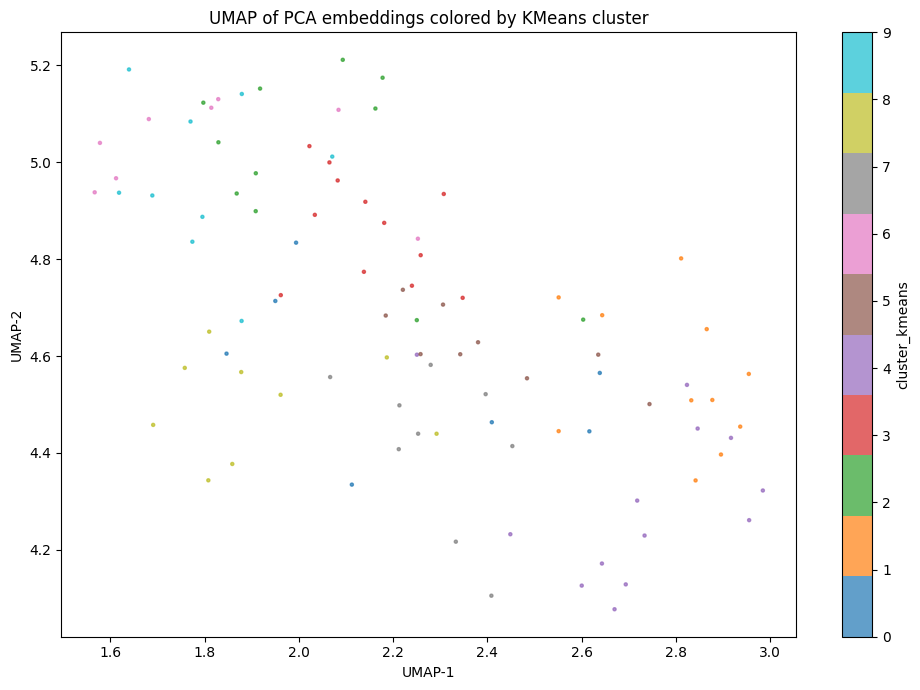

In [ ]:
# UMAP for k-means
plt.figure(figsize=(10, 7))
sc = plt.scatter(
    X_umap15[:, 0],
    X_umap15[:, 1],
    c=labels_kmeans,
    s=5,
    alpha=0.7,
    cmap="tab10"
)
plt.colorbar(sc, label="cluster_kmeans")
plt.title("UMAP of PCA embeddings colored by KMeans cluster")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.tight_layout()
#out_path = "umap_pca_clusters_kmeans_100.png"
#plt.savefig(out_path, dpi=300)
plt.show()
plt.close()

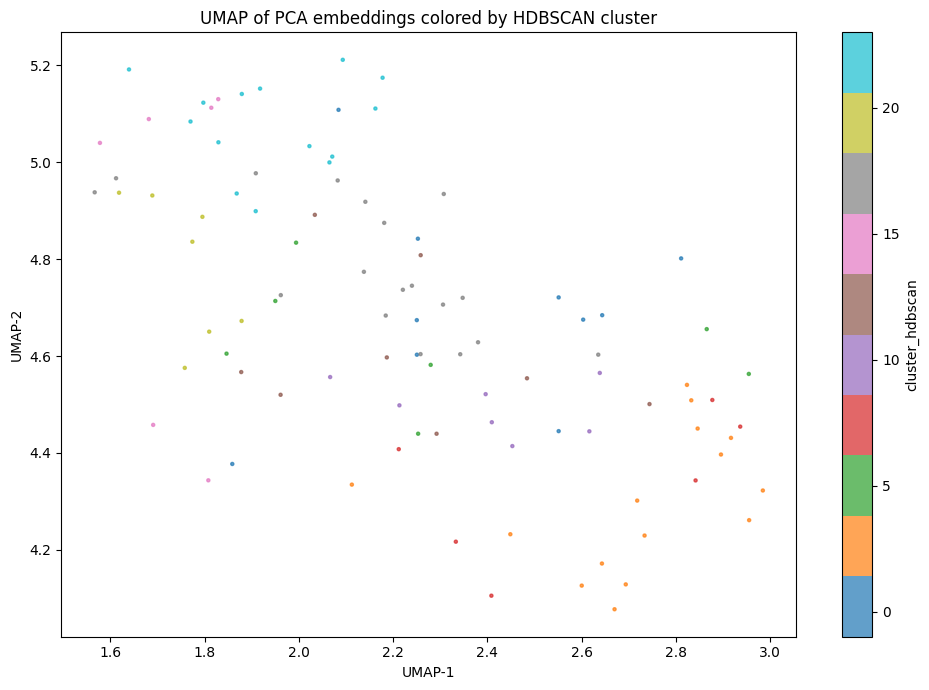

In [ ]:
# UMAP for Hdbscan
plt.figure(figsize=(10, 7))
sc = plt.scatter(
    X_umap15[:, 0],
    X_umap15[:, 1],
    c=labels_db,
    s=5,
    alpha=0.7,
    cmap="tab10"
)
plt.colorbar(sc, label="cluster_hdbscan")
plt.title("UMAP of PCA embeddings colored by HDBSCAN cluster")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.tight_layout()
#out_path = "umap_pca_clusters_hdbscan_100.png"
#plt.savefig(out_path, dpi=300)
plt.show()
plt.close()

### Analysis